<a href="https://colab.research.google.com/github/karencfisher/Hotel-Cancellations/blob/master/notebooks/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installations of dependencies

!pip install category_encoders==2.*
!pip install eli5

!wget https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py

!pip install pdpbox
!pip install shap


     |████████████████████████████████| 81kB 2.2MB/s 
     |████████████████████████████████| 112kB 2.7MB/s 
--2020-06-16 15:10:25--  https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11738 (11K) [text/plain]
Saving to: ‘tools.py’

tools.py            100%[===================>]  11.46K  --.-KB/s    in 0s      

2020-06-16 15:10:25 (72.4 MB/s) - ‘tools.py’ saved [11738/11738]

     |████████████████████████████████| 57.7MB 70kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=1322a507d576f1ccca025bd32ea30d7417c4b3498116d9d6f4e551f893e4b326
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3

In [2]:
# Import libraries

import tools
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import category_encoders as ce

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder,  StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

In [0]:
# Load dataset

url = 'https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/hotel_bookings.csv'
df = pd.read_csv(url)

# Correct some target values -- should be 'no-show' or 'cancellation' when checkout and
# arrival dates same indicating no stay
df = tools.fixTarget(df)

# Convert no shows to cancellations
df['reservation_status'] = df['reservation_status'].replace('No-Show', 'Canceled')

# Prepare training, validation, and test sets
X = df.drop('reservation_status', axis=1)
y = df['reservation_status']
y = y == 'Canceled'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,
                                                    stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.3,
                                                  random_state=42, stratify=y_train)

In [4]:
pipe = make_pipeline(tools.wrangleData(max_cardinality=50),
                          ce.OrdinalEncoder(),
                          SimpleImputer(),
                          SelectKBest(score_func=chi2, k='all'))

pipe.fit(X_train, y_train)

scores = pd.Series(pipe.named_steps['selectkbest'].scores_, 
                   pipe.named_steps['wrangledata'].columns_)

scores.sort_values(ascending=False)

lead_time                      504564.783473
days_in_waiting_list            19539.001590
previous_cancellations           5663.770897
total_of_special_requests        3606.199705
room_type_changed                2791.917582
booking_changes                  2333.623388
required_car_parking_spaces      2157.184783
deposit_type                     1222.317541
market_segment                    292.399885
is_repeated_guest                 208.829921
customer_type                     201.617237
hotel                             125.503267
nights_stay                        29.704672
adults                             25.129085
arrival_date_week_number           19.036394
meal                                3.657148
adr                                 0.427247
dtype: float64

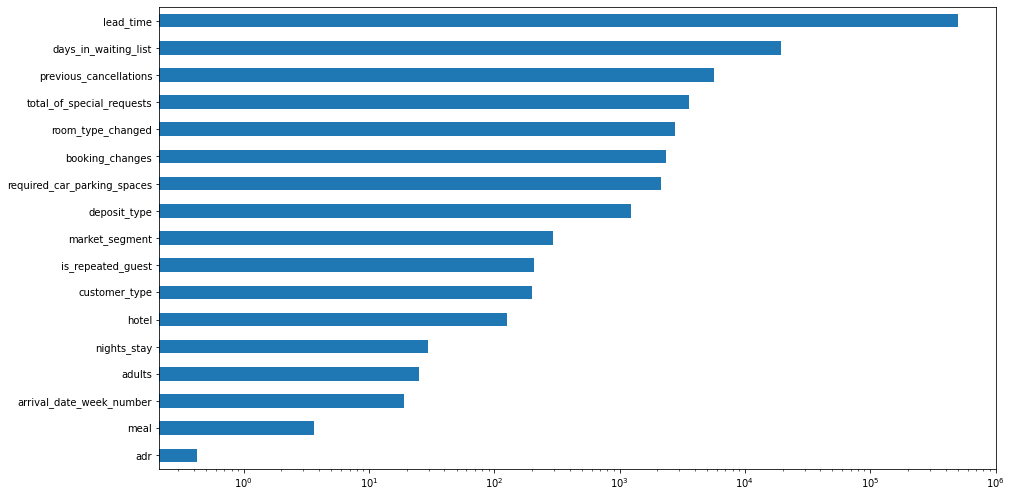

In [5]:
plt.figure(figsize=(15, len(pipe.named_steps['wrangledata'].columns_) / 2))
scores.sort_values().plot.barh()
plt.xscale('log');

In [6]:
baseline = make_pipeline(tools.wrangleData(max_cardinality=50),
                         ce.OrdinalEncoder(),
                         SimpleImputer(),
                         DummyClassifier())

tools.tryModel(baseline, X_train, y_train, X_val, y_val)



Train score = 53.03328148236782 %
Validate score = 53.0472239948947 %




'Confusion Matrix'

,False,True
False,9758,5879
True,5841,3594


'Metrics'

,precision,recall,f1-score
False,0.625553,0.624033,0.624792
True,0.379394,0.380922,0.380157


In [7]:
lr_pipeline = make_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(),
                            SimpleImputer(),
                            StandardScaler(),
                            LogisticRegression(n_jobs=-1,
                                               solver='lbfgs'))

tools.tryModel(lr_pipeline, X_train, y_train, X_val, y_val)



Train score = 79.15591186475444 %
Validate score = 80.10928525845564 %




'Confusion Matrix'

,False,True
False,14603,1034
True,3953,5482


'Metrics'

,precision,recall,f1-score
False,0.786969,0.933875,0.854151
True,0.841314,0.581028,0.687355


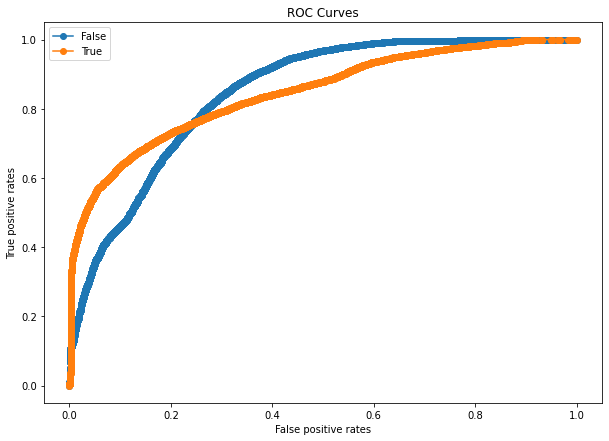

In [8]:
tools.ROCcurves(y_val, X_val, lr_pipeline)

In [9]:
model = RandomForestClassifier(random_state=42,
                              n_jobs=-1,
                              max_depth=35,
                              min_samples_leaf=1,
                              min_samples_split=2,
                              class_weight='balanced',
                              n_estimators=100)

rf_pipeline1 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                             ce.OrdinalEncoder(),
                             SimpleImputer(),
                             RandomUnderSampler(random_state=42),
                             model)

tools.tryModel(rf_pipeline1, X_train, y_train, X_val, y_val)



Train score = 95.83084049845301 %
Validate score = 84.70804084237396 %




'Confusion Matrix'

,False,True
False,13418,2219
True,1615,7820


'Metrics'

,precision,recall,f1-score
False,0.892570,0.858093,0.874992
True,0.778962,0.828829,0.803122


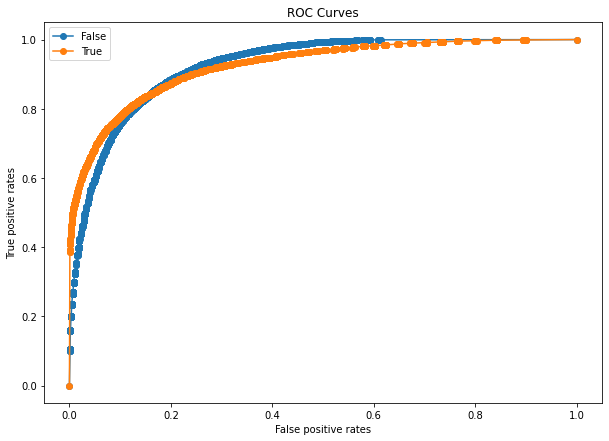

In [10]:
tools.ROCcurves(y_val, X_val, rf_pipeline1)

In [0]:
trans = make_pipeline(tools.wrangleData(max_cardinality=50),
                      ce.OrdinalEncoder(),
                      SimpleImputer())

trans.fit(X_train, y_train)
wrangler = trans.named_steps['wrangledata']
encoder = trans.named_steps['ordinalencoder']

X_train_enc = trans.transform(X_train)
X_train_enc, y_train_enc = RandomUnderSampler(random_state=42).fit_sample(X_train_enc, y_train)
X_train_enc = pd.DataFrame(X_train_enc, columns=wrangler.columns_)
X_val_enc = pd.DataFrame(trans.transform(X_val), columns=wrangler.columns_)

model.fit(X_train_enc, y_train_enc)

cat_features = tools.wrangleData().transform(X_train). \
                    select_dtypes(exclude='number').columns.tolist()

Accuracy score



deposit_type                   0.090627
lead_time                      0.064574
total_of_special_requests      0.060873
market_segment                 0.049593
previous_cancellations         0.032786
customer_type                  0.029411
adr                            0.028725
room_type_changed              0.022503
nights_stay                    0.020429
arrival_date_week_number       0.017677
required_car_parking_spaces    0.015515
hotel                          0.015451
booking_changes                0.013170
adults                         0.007610
meal                           0.006414
days_in_waiting_list           0.000941
is_repeated_guest              0.000630
dtype: float64

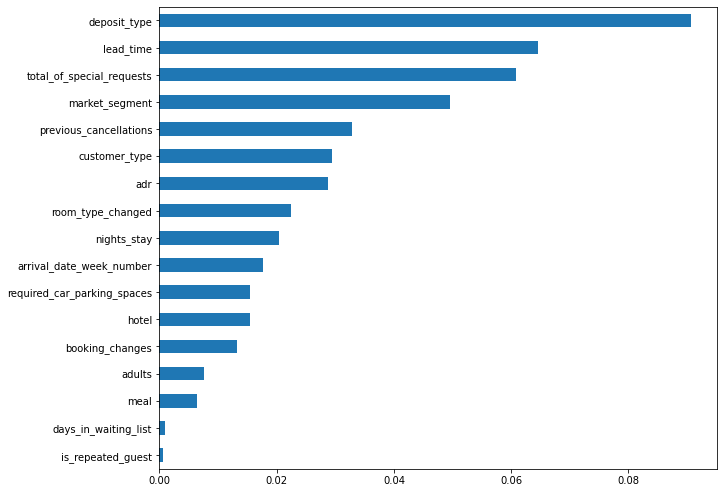

In [12]:
tools.permutationImports(model, X_val_enc, y_val)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


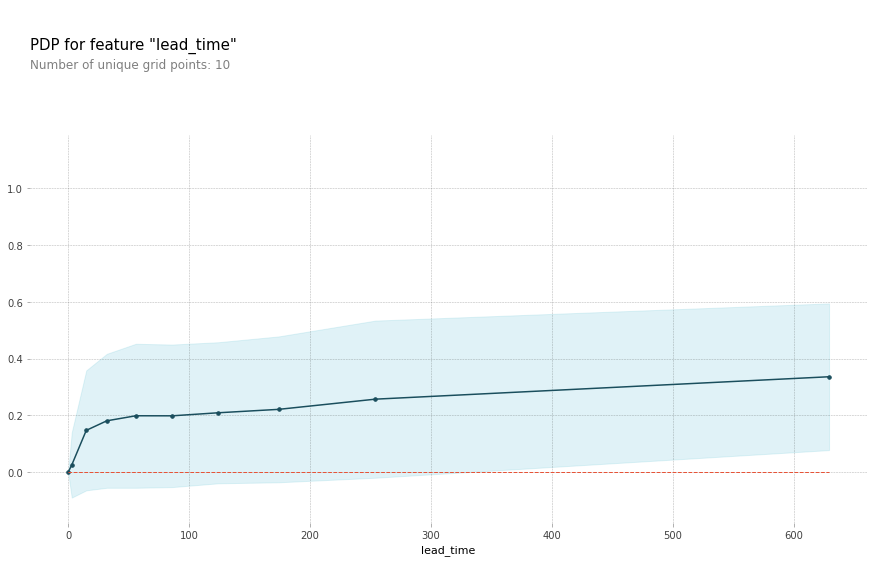

In [13]:
tools.plotFeature(model, X_val_enc, 'lead_time')

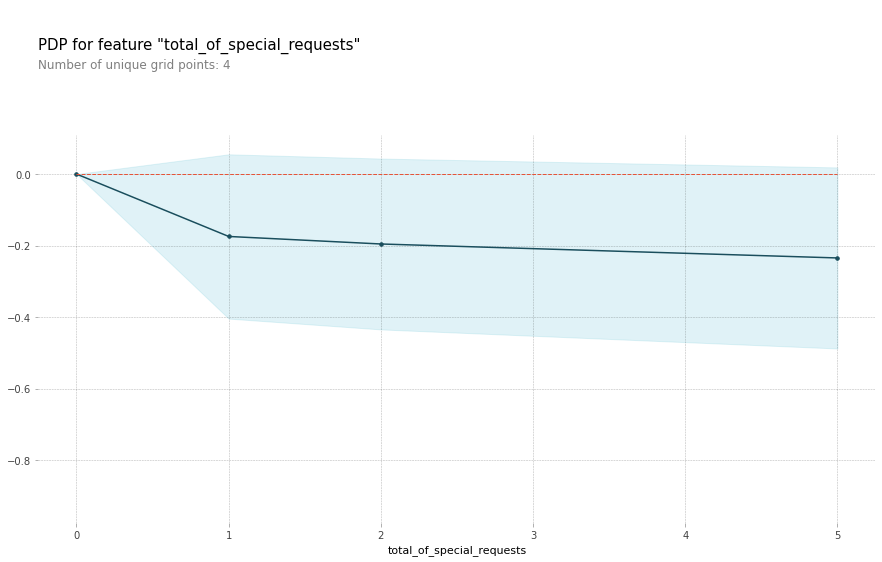

In [14]:
tools.plotFeature(model, X_val_enc, 'total_of_special_requests', cat_features, encoder.mapping)

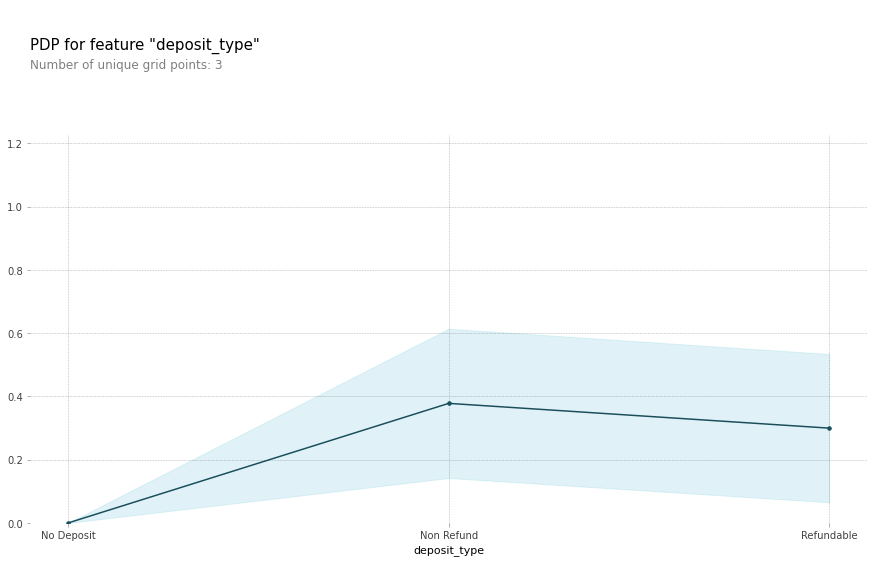

In [15]:
tools.plotFeature(model, X_val_enc, 'deposit_type', cat_features, encoder.mapping)

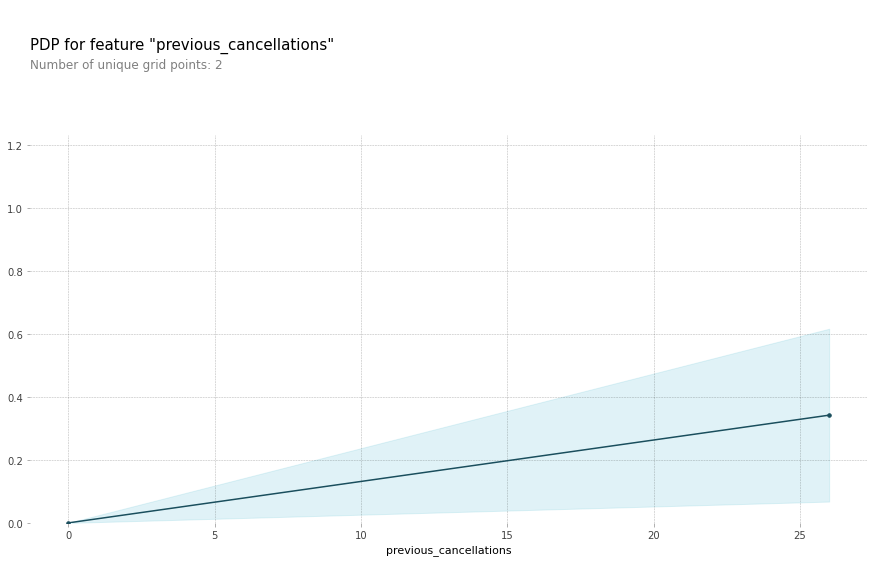

In [16]:
tools.plotFeature(model, X_val_enc, 'previous_cancellations')

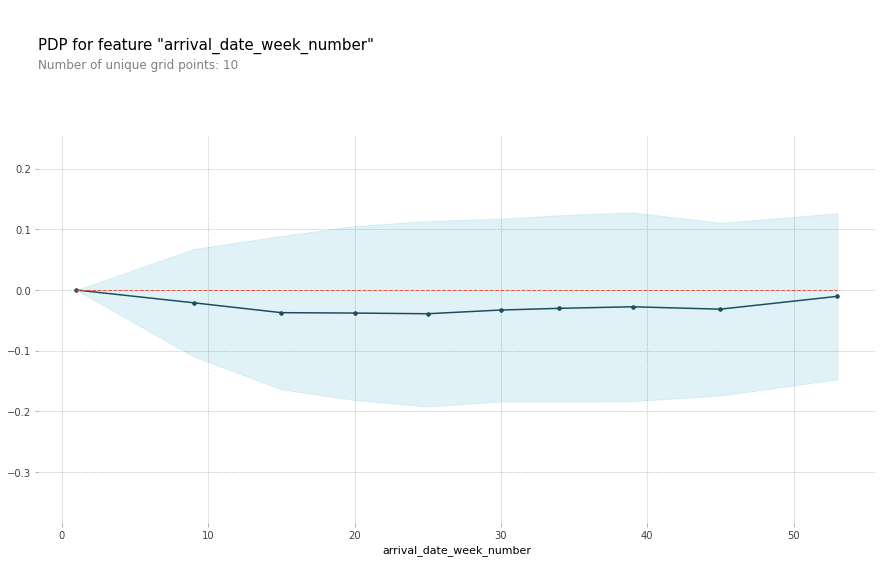

In [17]:
tools.plotFeature(model, X_val_enc, 'arrival_date_week_number')

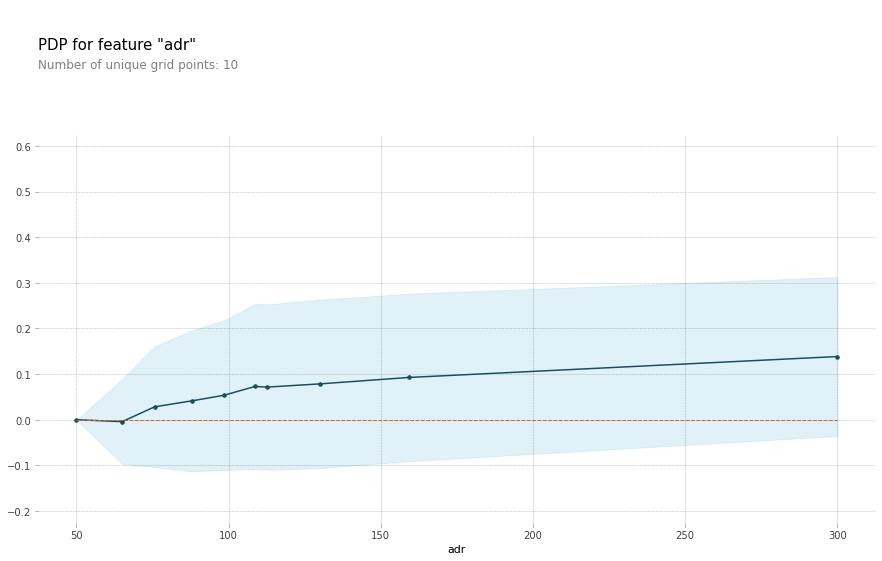

In [19]:
tools.plotFeature(model, X_val_enc, 'adr')

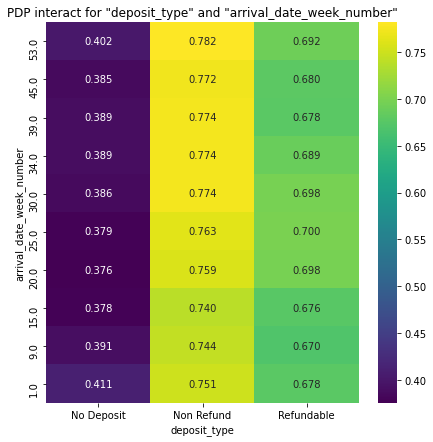

In [18]:
tools.plotFeatures(model, X_val_enc, ['deposit_type', 'arrival_date_week_number'], cat_features, encoder.mapping)

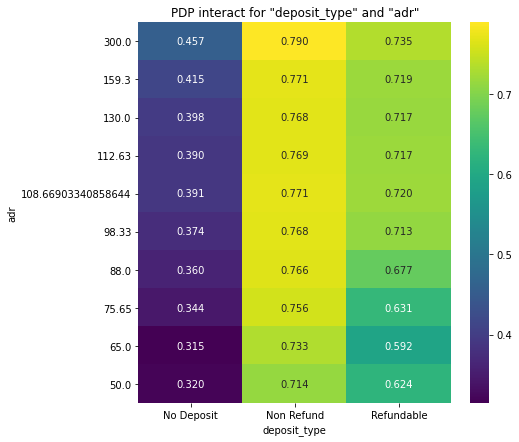

In [20]:
tools.plotFeatures(model, X_val_enc, ['deposit_type', 'adr'], cat_features, encoder.mapping)

In [0]:
def shapPlot(model, input_data):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(input_data)

    shap.initjs()
    return shap.force_plot(base_value=explainer.expected_value[1],
                    shap_values=shap_values[1],
                    features=input_data,
                    link='logit')

In [16]:
df = X_val_enc.copy()
y_pred = model.predict_proba(X_val_enc)
df['predicted_status'] = y_pred[:, 1]
df.sort_values(by='predicted_status', ascending=False).head(10)

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed,predicted_status
25071,2.0,274.0,29.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,62.000000,0.0,0.0,4.0,0.0,1.0
17093,1.0,215.0,23.0,2.0,4.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,110.000000,0.0,0.0,3.0,0.0,1.0
2814,1.0,222.0,38.0,2.0,4.0,2.0,0.0,25.0,0.0,2.0,0.0,1.0,108.669033,0.0,0.0,6.0,0.0,1.0
5811,2.0,169.0,23.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,170.000000,0.0,0.0,3.0,0.0,1.0
9722,2.0,360.0,42.0,2.0,2.0,2.0,0.0,1.0,0.0,2.0,0.0,3.0,62.000000,0.0,0.0,2.0,0.0,1.0
17100,1.0,222.0,38.0,2.0,4.0,2.0,0.0,25.0,0.0,2.0,0.0,1.0,108.669033,0.0,0.0,6.0,0.0,1.0
15329,2.0,88.0,19.0,1.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,120.000000,0.0,0.0,2.0,0.0,1.0
9726,2.0,25.0,20.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,90.000000,0.0,0.0,3.0,0.0,1.0
15330,2.0,274.0,29.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,62.000000,0.0,0.0,4.0,0.0,1.0
2822,2.0,113.0,23.0,1.0,2.0,6.0,0.0,0.0,0.0,2.0,0.0,1.0,100.000000,0.0,0.0,3.0,0.0,1.0


In [17]:
df.sort_values(by='predicted_status').head(10)

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed,predicted_status
20218,2.0,92.0,46.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,90.00,0.0,0.0,1.0,0.0,0.0
3499,1.0,136.0,13.0,2.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,84.00,0.0,0.0,3.0,0.0,0.0
18804,2.0,7.0,17.0,1.0,2.0,6.0,0.0,0.0,0.0,1.0,0.0,1.0,67.00,1.0,0.0,2.0,0.0,0.0
22786,2.0,82.0,36.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,98.25,1.0,2.0,1.0,0.0,0.0
22781,2.0,282.0,24.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,48.0,2.0,73.33,0.0,1.0,3.0,0.0,0.0
16089,1.0,0.0,45.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,63.00,1.0,0.0,1.0,0.0,0.0
22777,2.0,227.0,22.0,3.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,157.50,0.0,2.0,3.0,0.0,0.0
18812,2.0,50.0,23.0,3.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,159.30,0.0,2.0,2.0,1.0,0.0
3495,2.0,215.0,48.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,75.00,0.0,0.0,3.0,0.0,0.0
9859,2.0,377.0,42.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,115.00,0.0,1.0,2.0,0.0,0.0


In [18]:
row = X_val_enc.iloc[[25071]]
row

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
25071,2.0,274.0,29.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,62.0,0.0,0.0,4.0,0.0


In [19]:
shapPlot(model, row)

In [20]:
row = X_val_enc.iloc[[9722]]
row

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
9722,2.0,360.0,42.0,2.0,2.0,2.0,0.0,1.0,0.0,2.0,0.0,3.0,62.0,0.0,0.0,2.0,0.0


In [21]:
shapPlot(model, row)

In [22]:
row = X_val_enc.iloc[[93]]
row

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
93,2.0,63.0,30.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,114.3,1.0,2.0,2.0,0.0


In [23]:
shapPlot(model,row)

In [24]:
row = X_val_enc.iloc[[9575]]
row

,hotel,lead_time,arrival_date_week_number,adults,meal,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
9575,2.0,49.0,27.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,116.7,1.0,1.0,3.0,0.0


In [25]:
shapPlot(model, row)